<a href="https://colab.research.google.com/github/jackiecoughlin/machineLearning/blob/main/neural_digit_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Optional: Use a default style
plt.style.use('seaborn-v0_8-muted')

# TensorFlow logging cleanup
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# Print options
np.set_printoptions(precision=2)


Softmax Function

A multiclass neural network generates N outputs. One output is selected as the predicted answer.
In the output layer, a vector z is generated by a linear function which is fed into a softmax function.
The softmax function converts z into a probability distribution.
After applying softmax, each output will be between 0 and 1 and the outputs will sum to 1 (which can be interpreted as probabilities)

The softmax function can be written as the following:
a_j = (e^z_j)/((sum from k = 0 to k = N - 1)e^z_k)
where z = w * x + b and N is the number of feature/categories in output layer

In [ ]:
# Softmax Function
def my_softmax(z):
  """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """

  N = len(z)
  a = np.zeros(N)
  ez_sum = 0

  # compute sum of e^z_k (denominator)
  for k in range(N):
    ez_sum += np.exp(z[k])

  # compute actual softmax calculation
  for j in range(N):
    a[j] = np.exp(z[j])/ez_sum

  return a


In [ ]:
# Testing for softmax function
def test_my_softmax():
    # Test 1: simple vector
    z = np.array([1, 0, 0])
    a = my_softmax(z)
    expected = np.array([0.57611688, 0.21194156, 0.21194156])
    print("Test 1:", np.allclose(a, expected, atol=1e-5))

    # Test 2: symmetric input (should give equal probabilities)
    z = np.array([5, 5, 5])
    a = my_softmax(z)
    expected = np.array([1/3, 1/3, 1/3])
    print("Test 2:", np.allclose(a, expected, atol=1e-5))

    # Test 3: more extreme differences
    z = np.array([10, 0, -10])
    a = my_softmax(z)
    expected = np.exp(z) / np.sum(np.exp(z))
    print("Test 3:", np.allclose(a, expected, atol=1e-5))

    # Test 4: check sum = 1
    z = np.array([2, 3, 7])
    a = my_softmax(z)
    print("Test 4 (sums to 1):", np.isclose(np.sum(a), 1.0))

    # Test 5: check output shape
    print("Test 5 (shape):", a.shape == z.shape)

test_my_softmax()


Test 1: True
Test 2: True
Test 3: True
Test 4 (sums to 1): True
Test 5 (shape): True


Problem Statement

Objective: Implemenet a neural netowrk to do multiclass classification utilizing the softmax function

Problem Statement: A neural network will be implemented to recognize 10 handwritten digits, 0-9 (automated handwritten digit recognition). This is a multiclass classification task where one of n choices is selected.



1. Load the Dataset

The data set contains 5000 training examples of handwritten digits

Each training example is a 20 pixel X 20-pixel grayscale image of the digit
Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
Each training examples becomes a single row in our data matrix X.
This gives us a 5000 x 400 matrix X where every row is a training example of a handwritten digit image.


The second part of the training set is a 5000 x 1 dimensional vector y that contains labels for the training set
y = 0 if the image is of the digit 0, y = 4 if the image is of the digit 4 and so on.



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving X.npy to X.npy
Saving y.npy to y.npy


In [ ]:
# Load Dataset
X = np.load('X.npy')
y = np.load('y.npy')


2. Sanity Check: view the variables

In [ ]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [ ]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


Also, check dimensions of variables as a sanity check by printing the shape of X and y.

In [ ]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


3. Visualizing the Data

Visualize a subset of the training set

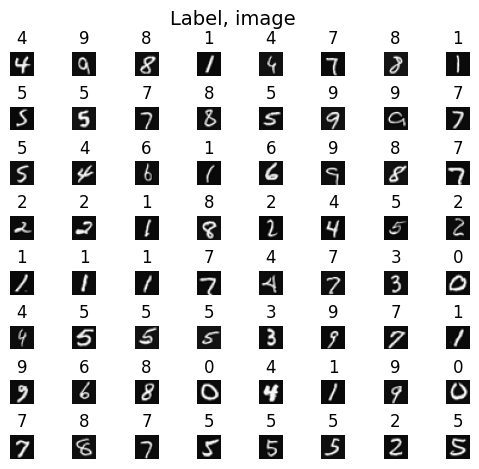

In [ ]:
# The code randomly selects 64 rows from X, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together
# The label for each image is displayed above the image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
  # Select random indices
  random_index = np.random.randint(m)
  # Select rows corresponding to the random indices and reshape the image
  X_random_reshaped = X[random_index].reshape((20,20)).T

  # Display the image
  ax.imshow(X_random_reshaped, cmap='gray')

  # Display the label above the image
  ax.set_title(y[random_index,0])
  ax.set_axis_off()
  fig.suptitle("Label, image", fontsize=14)

4. Model Representation



In [ ]:
from google.colab import files
uploaded_2 = files.upload()

Saving Screenshot 2025-12-09 134311.png to Screenshot 2025-12-09 134311.png


(np.float64(-0.5), np.float64(627.5), np.float64(207.5), np.float64(-0.5))

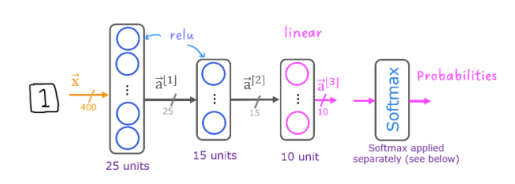

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Get the filename from the uploaded_2 dictionary
# Assuming only one file was uploaded, we can get the first key.
image_filename = next(iter(uploaded_2))

img = Image.open(image_filename)
plt.imshow(img)
plt.axis('off')

The neural netowrk used is illustrated in the figure above. It has 2 dense layers with reLU activations followed by an output layer with a linear activation. The inputs are pizel values of digit images (since images are of size 20 x 20, this gives 400 inputs).

The parameters have dimensions that are sized for a neural network with 25 units in layer 1, 15 units in layer 2, and 10 output units in layer 3, one for each digit. The dimensions are as follows: if network has s_in units in a layer, and s_out units in the next layer, then W will be of dimension s_sin X s_out and b will be a vector with s_out elements.

The shapes of W and b are:

*   layer1: W1 is (400, 25) and b1 is (25,)
*   layer2: W2 is (25, 15) and b2 is (15,)
*   layer3: W3 is (15, 10) and b3 is (10,)





4. Tensorflow Model Implementation

Tensorflow models are built layer by layer. A layer's input dimensions (s_in) are already calculated. User specifies the output dimensions and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specificied in the model.fit statement.

5. Softmax Placement

Numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. This has implications when building the model and using the model.

Building:

*   The final Dense layer should use 'linear' activation (this is effectively no activation)
*   The model.compile statement will indicate this by including from_logits=True
*   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
*   In the case of SparseCategoricalCrossentropy, the target is the expected digit (0-9)

Using the model:

*   The outputs are not probabilities (if you want probabilities, apply a softmax function)

In [ ]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        tf.keras.layers.Dense(units=25, activation='relu'),
        tf.keras.layers.Dense(units=15, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='linear')
    ], name = "my_model"
)

In [ ]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,727 (123.94 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,152 (82.63 KB)

Sanity Check: Examine the weights to verify that tensorflow produced the same dimensions as previously calculated.

In [ ]:
[layer1, layer2, layer3] = model.layers

In [ ]:
# Examine Weights shapes
# Expected output
# W1 shape = (400, 25), b1 shape = (25,)
# W2 shape = (25, 15), b2 shape = (15,)
# W3 shape = (15, 10), b3 shape = (10,)

W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


The following code defines a loss function, SparseCategoricalCrossentropy and indicates the softmax should be included with the loss calculation by adding from_logits=True.

The code defines an optimizer (Adam)


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

# Specifies the entire data set should be applied during training 40 times
history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0129
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

6. Loss (cost)

Ideally, the cost/loss will decrease as the number of iterations of the algorithm increases. Tensorflow refers to the cost as loss. Above, the loss displayed each epoch as model.fit was executing. The .fit method returns a variety of metrics including the loss, which is captured in the history variable. The loss is examined in a plot below.

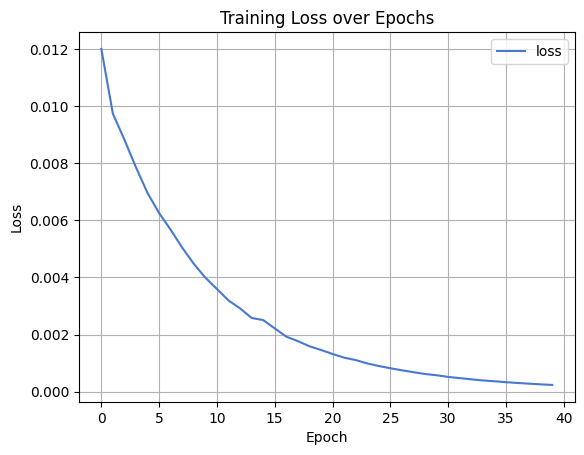

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_tf(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_tf(history)

7. Prediction

Making a prediction using Keras predict

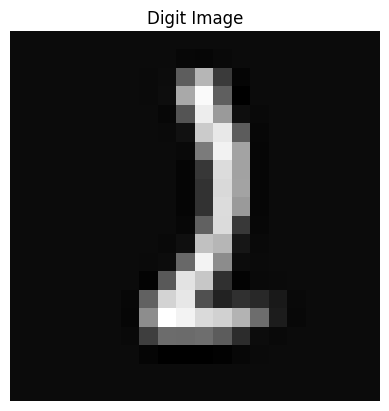

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
 predicting a Two: 
[[-19.     2.2   10.9    2.65 -18.55 -16.65  -6.75  -2.06 -11.77 -22.1 ]]
 Largest Prediction index: 2


In [ ]:
# display_digit function definition
def display_digit(image_vector):
    # Reshape the 400-dimensional vector to a 20x20 image
    image_reshaped = image_vector.reshape((20, 20)).T

    # Display the image
    plt.imshow(image_reshaped, cmap='gray')
    plt.axis('off')
    plt.title('Digit Image')
    plt.show()

image_of_two = X[1015]
display_digit(image_of_two)

# prediction
prediction = model.predict(image_of_two.reshape(1, 400))

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

The largest output is prediction[2], indicating the predicted digit is a '2'. If the probelm only requires  selection, this is sufficient. Use NumPy argmax to select it. If the problem requires a probability, a softmax is required.

In [ ]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[1.03e-13 1.67e-04 1.00e+00 2.61e-04 1.63e-13 1.09e-12 2.16e-08 2.36e-06
  1.43e-10 4.65e-15]]
Total of predictions: 1.000


To return an integer representing the predicted target, you want the index of the largest probability. This is accomplished with the Numpy argmax function.

In [ ]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Now, we will compare the predictions versus the labels for a random sample of 64 digits.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

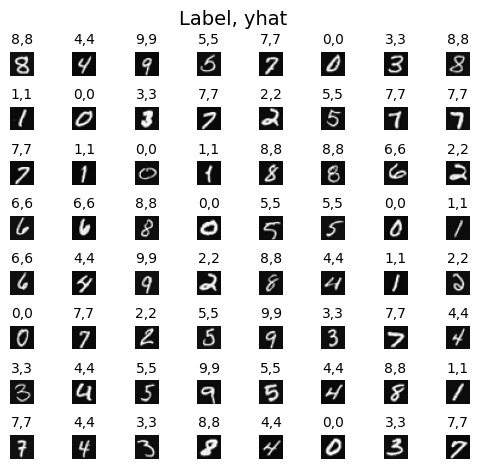

In [ ]:
from numpy.random.mtrand import f
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
for i, ax in enumerate(axes.flat):
  # Select random indices
  random_index = np.random.randint(m)

  # Select rows corresponding to the random indices and reshape the image
  X_random_reshaped = X[random_index].reshape((20, 20)).T

  # Display the image
  ax.imshow(X_random_reshaped, cmap='gray')

  # Predict using the neural network
  prediction = model.predict(X[random_index].reshape(1,400))
  prediction_p = tf.nn.softmax(prediction)
  yhat = np.argmax(prediction_p)

  # Display the label above the image
  ax.set_title(f"{y[random_index,0]},{yhat}", fontsize=10)
  ax.set_axis_off()

fig.suptitle("Label, yhat", fontsize=14)
plt.show()

